# <center> Graph and Activity stats from dataset

Imports.

In [1]:
import os
import util
from time import time
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

Choose dataset and edit `out_path`. <b> Attention ! </b> Si `truegraph` la liste d'adjacence doit être au format $leader follower$.

In [2]:
data_path = "../Datasets/weibo_rtid.txt"
out_path = "../DataAnalysis/weibo_cascade/"
cascade = True
truegraph = False

Open outfile (and create out folder if necessary).

In [3]:
graph_stats = open(out_path + "graph_stats.txt", 'w')

Author dict creation.

In [4]:
if truegraph:
    Author = None
else:
    Author = util.get_authors(data_path)

### Graph construction
Construit un graphe nx à partir du dataset.

In [5]:
if truegraph:
    G = util.nxgraph_from_adjList(data_path)
else:
    G = util.nxgraph_from_trace(data_path, cascade, Author)

### Basic stats

In [6]:
%%capture cap
print("Number of nodes: {}".format(G.number_of_nodes()))
print("Number of edges: {}".format(G.number_of_edges()))

In [7]:
print(cap)
graph_stats.write(cap.stdout+'\n')

Number of nodes: 1340816
Number of edges: 32448742



52

### Degrees stats

Les degrés.

In [8]:
deg = {'degrees': [x[1] for x in G.degree()], 
       'in_degrees': [x[1] for x in G.in_degree()],
       'out_degrees': [x[1] for x in G.out_degree()]}

Calcul des stats.

In [9]:
%%capture cap

for d_type in deg.keys():
    d = deg[d_type]
    print("----- Stats for {} -----".format(d_type))
    print("Mean: ", np.mean(d))
    print("Median: ", np.median(d))
    print("Min: ", np.min(d))
    print("Max: ", np.max(d))
    for percent in [25, 75, 90, 95, 99]:
        print("{}% <= {}".format(percent, np.percentile(d, percent)))
    print()

Print and save.

In [10]:
print(cap)
graph_stats.write(cap.stdout+'\n')

----- Stats for degrees -----
Mean:  48.40148387250749
Median:  34.0
Min:  1
Max:  3626
25% <= 12.0
75% <= 70.0
90% <= 112.0
95% <= 142.0
99% <= 216.0

----- Stats for in_degrees -----
Mean:  24.200741936253745
Median:  17.0
Min:  0
Max:  452
25% <= 6.0
75% <= 35.0
90% <= 56.0
95% <= 71.0
99% <= 108.0

----- Stats for out_degrees -----
Mean:  24.200741936253745
Median:  17.0
Min:  0
Max:  3626
25% <= 6.0
75% <= 35.0
90% <= 56.0
95% <= 71.0
99% <= 108.0




459

### Degrees distribution
On affiche et on enregistre la distribution des degrés.

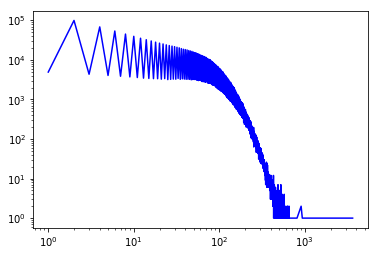

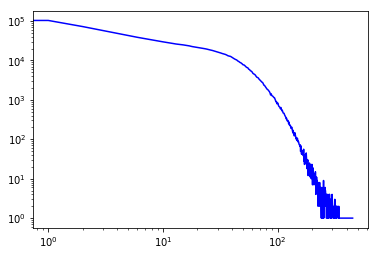

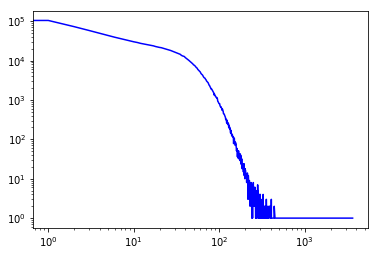

In [11]:
for d_type in deg.keys():
    
    # on récupère les degrés
    d = np.array(sorted(deg[d_type]))
    
    # on compte les occurences
    nb_occ = np.bincount(d)
    nb_occ = nb_occ[nb_occ > 0]

    # on récupère les valeurs uniques de d
    d = np.unique(d)

    # plot
    plt.loglog(d, nb_occ, color='blue')
    
    # save & show
    plt.savefig(out_path + d_type + "_distrib_log.pdf")
    plt.show()
    plt.close()

### Connected components basic stats

In [12]:
%%capture cap

start = time()
cc_sizes = {'weakly': [len(c) for c in nx.weakly_connected_components(G)],
            'strongly': [len(c) for c in nx.strongly_connected_components(G)]}

print("Number of weakly connected components: {} (calculated in {})"
      .format(len(cc_sizes['weakly']), time()-start))
print("Number of strongly connected components: {} (calculated in {})"
      .format(len(cc_sizes['strongly']), time()-start))

In [13]:
print(cap)
graph_stats.write(cap.stdout+'\n')

Number of weakly connected components: 38 (calculated in 83.21484684944153)
Number of strongly connected components: 8066 (calculated in 83.21484684944153)



157

### Connected components sizes stats

In [14]:
%%capture cap

for s_type in cc_sizes.keys():
    s = cc_sizes[s_type]
    print("----- Stats for {} connected components sizes -----".format(s_type))
    print("Mean: ", np.mean(s))
    print("Median: ", np.median(s))
    print("Min: ", np.min(s))
    print("Max: ", np.max(s))
    for percent in [25, 75, 90, 95, 99]:
        print("{}% <= {}".format(percent, np.percentile(s, percent)))
    print()

In [15]:
print(cap)
graph_stats.write(cap.stdout+'\n')

----- Stats for weakly connected components sizes -----
Mean:  35284.63157894737
Median:  1.0
Min:  1
Max:  1340768
25% <= 1.0
75% <= 2.0
90% <= 2.0
95% <= 2.1499999999999986
99% <= 844684.9500000034

----- Stats for strongly connected components sizes -----
Mean:  166.2305975700471
Median:  1.0
Min:  1
Max:  1332743
25% <= 1.0
75% <= 1.0
90% <= 1.0
95% <= 1.0
99% <= 1.0




376

### Connected components sizes distrib
Encore une fois on ne garde que les valeurs <p%tile.

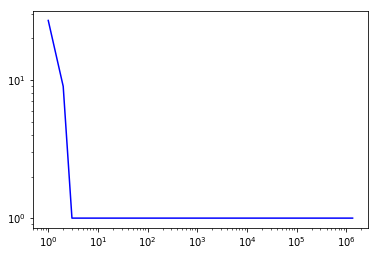

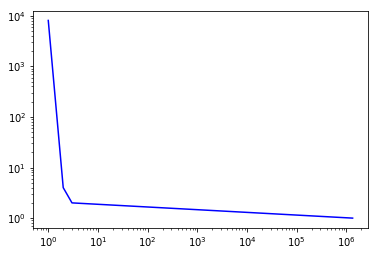

In [16]:
for s_type in cc_sizes.keys():

    # on récupère les valeurs
    d = np.array(sorted(cc_sizes[s_type]))
    
    # on compte les occurences
    nb_occ = np.bincount(d)
    nb_occ = nb_occ[nb_occ > 0]

    # on récupère les valeurs uniques de d
    d = np.unique(d)

    # plot
    plt.loglog(d, nb_occ, color='blue')
    
    # save & show
    plt.savefig(out_path + "{}_connected_components_sizes_distrib_log.pdf".format(s_type))
    plt.show()
    plt.close()

### Custom wedge metric

<center>
$\frac{\sum_{\text{user }i}LF - L \cap F}{\sum_{\text{user }i}LF - L \cap F + \frac{1}{2}(L(L-1) + F(F-1))} = \frac{2\sum_{\text{user }i}LF - L \cap F}{\sum_{\text{user }i}(L+F)^2-L-F-2L \cap F}$
</center>

In [17]:
numerator = 0
denominator = 0

for i in G.nodes:
    leaders = set(G.predecessors(i))
    followers = set(G.successors(i))
    friends = leaders.intersection(followers)
    if len(leaders) + len(followers) < 2:
        continue
    if leaders==followers and len(leaders)==1:
        continue
    L = len(leaders)
    F = len(followers)
    LintF = len(friends)
    numerator += L*F - LintF
    denominator += (L+F)**2 - L - F - 2*LintF

if denominator != 0:
    wedge_metric = 2 * numerator / denominator
else:
    wedge_metric = 0

In [18]:
print("Wedge_metric : ", wedge_metric)
graph_stats.write("Wedge_metric : {}".format(wedge_metric))

Wedge_metric :  0.5006313559087983


33

### Close graph_stats

In [19]:
graph_stats.close()

# Activity

### Nb tweets/retweets/retweeted stats

On compte le nb de tweets, retweets et retweeted par utilisateur.

In [20]:
count = dict()
count['tweets'], count['retweets'], count['retweeted'], total_time = util.get_activity(
    data_path, cascade, Author, divide_by_time=False, retweeted=True)

On affiche et on enregistre.

In [21]:
%%capture cap

for count_type in count.keys():
    c = np.array([*count[count_type].values()])
    print("----- Stats for {} per user -----".format(count_type))
    print("Total: ", c.sum())
    print("Mean: ", np.mean(c))
    print("Median: ", np.median(c))
    print("Min: ", np.min(c))
    maximum = np.max(c)
    print("Max: {} (user {})".format(maximum, [u for u in count['tweets'] if count[count_type][u]==maximum]))
    for percent in [25, 75, 90, 95, 99]:
        print("{}% <= {}".format(percent, np.percentile(c, percent)))
    print("Nb users with at least 1: ", c[c>0].shape[0])
    print("Nb users with 0: ", c[c==0].shape[0])
    print()

In [22]:
print(cap)
with open(out_path + "tweetsRetweets_stats.txt", 'w') as out:
    out.write(cap.stdout)
out.close()

----- Stats for tweets per user -----
Total:  232978
Mean:  0.17375836803856756
Median:  0.0
Min:  0
Max: 3718 (user [490872])
25% <= 0.0
75% <= 0.0
90% <= 0.0
95% <= 0.0
99% <= 2.0
Nb users with at least 1:  47555
Nb users with 0:  1293261

----- Stats for retweets per user -----
Total:  33307189
Mean:  24.84098414696722
Median:  17.0
Min:  0
Max: 1032 (user [1009966])
25% <= 6.0
75% <= 36.0
90% <= 57.0
95% <= 73.0
99% <= 114.0
Nb users with at least 1:  1334887
Nb users with 0:  5929

----- Stats for retweeted per user -----
Total:  33307189
Mean:  24.84098414696722
Median:  17.0
Min:  0
Max: 3718 (user [490872])
25% <= 6.0
75% <= 36.0
90% <= 57.0
95% <= 73.0
99% <= 114.0
Nb users with at least 1:  1339190
Nb users with 0:  1626




### Nb tweets/retweets/retweeted distrib

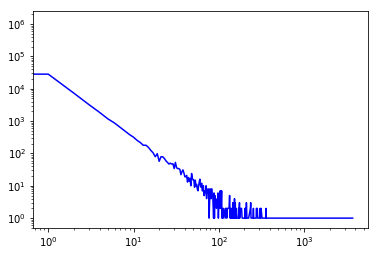

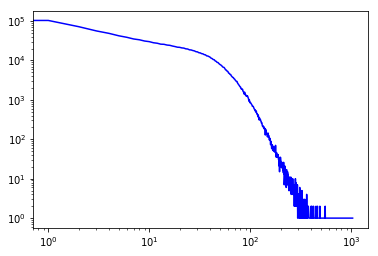

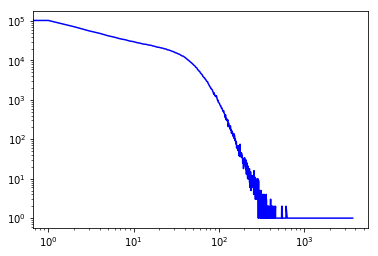

In [23]:
for count_type in count.keys():
   
    # on récupère les valeurs
    d = np.array(sorted([*count[count_type].values()]))
    
    # on compte les occurences
    nb_occ = np.bincount(d)
    nb_occ = nb_occ[nb_occ > 0]

    # on récupère les valeurs uniques de d
    d = np.unique(d)

    # plot
    plt.loglog(d, nb_occ, color='blue')
    
    # save & show
    plt.savefig(out_path + "number_of_{}_distrib_log.pdf".format(count_type))
    plt.show()
    plt.close()

### $\lambda, \mu, \nu$ stats

In [24]:
activity = {'lambda': np.array([*count['tweets'].values()]) / total_time, 
            'mu': np.array([*count['retweets'].values()]) / total_time, 
            'nu': np.array([*count['retweeted'].values()]) / total_time}

In [25]:
%%capture cap

for act_type in activity.keys():
    c = activity[act_type]
    print("----- Stats for {} -----".format(act_type))
    print("Mean: ", np.mean(c))
    print("Median: ", np.median(c))
    print("Min: ", np.min(c))
    maximum = np.max(c)
    print("Max: ", np.max(c))
    for percent in [25, 75, 90, 95, 99]:
        print("{}% <= {}".format(percent, np.percentile(c, percent)))
    print("Nb users with >0: ", c[c>0].shape[0])
    print("Nb users with 0: ", c[c==0].shape[0])
    print()

In [26]:
print(cap)
with open(out_path + "activity_stats.txt", 'w') as out:
    out.write(cap.stdout)
out.close()

----- Stats for lambda -----
Mean:  1.653994566121506e-09
Median:  0.0
Min:  0.0
Max:  3.539139936831588e-05
25% <= 0.0
75% <= 0.0
90% <= 0.0
95% <= 0.0
99% <= 1.90378694826874e-08
Nb users with >0:  47555
Nb users with 0:  1293261

----- Stats for mu -----
Mean:  2.3645970700573426e-07
Median:  1.618218906028429e-07
Min:  0.0
Max:  9.823540653066698e-06
25% <= 5.7113608448062197e-08
75% <= 3.426816506883732e-07
90% <= 5.425792802565909e-07
95% <= 6.948822361180901e-07
99% <= 1.0851585605131817e-06
Nb users with >0:  1334887
Nb users with 0:  5929

----- Stats for nu -----
Mean:  2.364597070057344e-07
Median:  1.618218906028429e-07
Min:  0.0
Max:  3.539139936831588e-05
25% <= 5.7113608448062197e-08
75% <= 3.426816506883732e-07
90% <= 5.425792802565909e-07
95% <= 6.948822361180901e-07
99% <= 1.0851585605131817e-06
Nb users with >0:  1339190
Nb users with 0:  1626


